# FINN - End-to-End Flow
-----------------------------------------------------------------

在本笔记本中，我们将展示如何采用在 MNIST 数据集上训练的简单、二值化、完全连接的网络，并将其部署到在 PYNQ 板上运行的自定义bit文件。

这个笔记本很长，有些单元（涉及 Vivado 合成）可能需要长达一个小时才能完成运行。 为了让您保存和恢复进度，我们会将各个步骤中生成的中间 ONNX 模型保存到磁盘，以便您可以直接跳回到上次中断的地方。



## Overview

FINN 编译器带有许多转换，可根据特定模式修改网络的 ONNX 表示。该笔记本将演示此类转换的可能序列，以将特定训练网络部署到硬件，如下图所示。

![](finn-design-flow-example.svg)


FINN 编译器带有许多转换，可根据特定模式修改网络的 ONNX 表示。该笔记本将演示此类转换的可能序列，以将特定训练网络一直到硬件，如下图所示。



白色区域显示相应步骤中网络表示的状态。彩色字段表示应用于网络以实现特定结果的转换。该图分为 5 个部分，用不同的颜色表示，每个部分都包含几个流程步骤。流程从左上角开始，带有 Brevitas 导出（绿色部分），然后是为 Vivado HLS 合成和 Vivado IPI 拼接（橙色部分）准备网络（蓝色部分），最后构建 PYNQ 覆盖bit文件并对其进行测试在 PYNQ 板上（黄色部分）。在图的右侧还有一个用于功能验证的附加部分（红色部分），我们不会在本笔记本中介绍。有关详细信息，请查看您可以在此处找到的验证笔记本 [here](tfc_end2end_verification.ipynb)

这个 Jupyter 笔记本是根据上述部分组织的。我们将使用以下辅助函数，`showSrc` 显示 FINN 库调用的源代码，`showInNetron` 显示当前转换步骤的 ONNX 模型。 Netron 显示是交互式的，但它们仅在主动运行笔记本时有效，而不是在 GitHub 上运行（即，如果您在 GitHub 上查看此内容，则只会看到空白方块）。

In [1]:
from finn.util.visualization import showSrc, showInNetron
from finn.util.basic import make_build_dir

    
build_dir = "/workspace/finn"

## Outline
-------------
1. [Brevitas export](#brev_exp)
2. [Network preparation](#nw_prep)
3. [Hardware build](#vivado)
4. [PYNQ deployment](#hw_test)

## 1. Brevitas export <a id='brev_exp'></a>
FINN 需要一个 ONNX 模型作为输入。 这可以是使用 Brevitas 训练的模型 [Brevitas](https://github.com/Xilinx/brevitas)。 Brevitas 是一个用于量化感知训练的 PyTorch 库，FINN Docker 镜像带有几个示例 Brevitas 网络[example Brevitas networks](https://github.com/Xilinx/brevitas/tree/master/brevitas_examples/bnn_pynq)。 为了展示 FINN 端到端流程，我们将使用 TFC-w1a1 模型作为示例网络。

首先必须导入一些东西。 然后可以使用预训练的权重加载模型。

In [2]:
import onnx
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo

tfc = get_test_model_trained("TFC", 1, 1)
bo.export_finn_onnx(tfc, (1, 1, 28, 28), build_dir+"/tfc_w1_a1.onnx")

Downloading: "https://github.com/Xilinx/brevitas/releases/download/bnn_pynq-r1/tfc_1w1a-45185b4d.pth" to /home/maltanar/.cache/torch/checkpoints/tfc_1w1a-45185b4d.pth
100%|██████████| 249073/249073 [00:00<00:00, 767315.58it/s]
/workspace/brevitas/brevitas_examples/bnn_pynq/models/FC.py:84: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = 2.0 * x - torch.tensor([1.0], device=x.device)


现在导出模型，加载预训练权重并保存在名称“lfc_w1_a1.onnx”下。 要可视化导出的模型，可以使用 Netron。 Netron 是神经网络的可视化工具，允许对网络属性进行交互式调查。 例如，您可以单击单个节点并查看属性。

In [3]:
showInNetron(build_dir+"/tfc_w1_a1.onnx")

Serving '/workspace/finn/tfc_w1_a1.onnx' at http://0.0.0.0:8081


现在我们有了 .onnx 格式的模型，我们可以使用 FINN 处理它。 为此，使用了 FINN `ModelWrapper` 。 它是 ONNX 模型的一个包装器，它提供了几个帮助函数，以便更容易地使用模型。

In [4]:
from finn.core.modelwrapper import ModelWrapper
model = ModelWrapper(build_dir+"/tfc_w1_a1.onnx")

现在模型已准备就绪，可以使用 Python 进行模拟。有关验证的 Jupyter 笔记本中描述了其工作原理，可在此处找到 [here](tfc_end2end_verification.ipynb#simpy).。

现在也可以用不同的方式处理模型。 FINN 的原理是分析和转换 pass可以应用于模型。 分析阶段提取有关模型的特定信息，并以字典的形式将其返回给用户。 转换过程更改模型并将更改后的模型返回到 FINN 流。

由于本笔记本中的目标是将模型处理到可以从中生成比特流，因此重点是为此所需的转换。 在下一节中，将更详细地讨论这些。

## 2. Network preparation <a id='nw_prep'></a>

* [FINN-style Dataflow Architectures](#dataflow_arch)
* [Tidy-up transformations](#basic_trafo)
* [Streamlining](#streamline)
* [Conversion to HLS layers](#hls_layers)
* [Creating a Dataflow Partition](#dataflow_partition)
* [Folding and Datawidth Converter, FIFO and TLastMarker Insertion](#folding)


在本节中，我们将通过一系列转换将网络置于可以拼接在一起以形成 FINN 式数据流架构的形式，从而产生高性能、高效率的 FPGA 加速器。

### FINN-style Dataflow Architectures <a id='dataflow_arch'></a>


我们首先快速回顾一下 FINN 风格的数据流架构。 此类架构的关键思想是通过将一定数量的计算资源专用于每一层来实现跨层和层内的并行化，如下图所示，取自 FINN-R 论文：[FINN-R paper](https://arxiv.org/pdf/1809.04570.pdf):

![](finn-hw-arch.png)



在实践中，计算数组是通过调用[finn-hlslib](https://github.com/Xilinx/finn-hlslib)库中优化的 Vivado HLS 构建块的函数来实例化的。 由于这些函数调用只能处理某些模式/情况，我们需要将网络转换成合适的形式，以便我们可以用这些函数调用替换网络层，这就是网络准备过程的目标。

### Tidy-up transformations <a id='basic_trafo'></a>

本节处理一些基本转换，它们像一种“tidy-up整理”一样应用于模型，使其更易于处理。它们没有出现在上图中，但它们在 FINN 流程的许多步骤中应用，以在转换后对模型进行后处理和/或为下一次转换做准备。

These transformations are:
* GiveUniqueNodeNames (提供唯一节点名称)
* GiveReadableTensorNames （提供可读张量名称）
* InferShapes （推断形状）
* InferDataTypes （推断数据类型）
* FoldConstants （折叠常数）
* RemoveStaticGraphInputs （删除静态图形输入）


在前两个转换（GiveUniqueNodeNames、GiveReadableTensorNames）中，图中的节点首先被赋予唯一的（通过枚举）名称，然后张量被赋予人可读的名称（基于节点名称）。以下两个转换（InferShapes、InferDataTypes）从模型属性中导出张量的形状和数据类型，并将它们设置在模型的 ValueInfo 中。这些转换几乎总是可以在没有负面影响的情况下应用，并且不会影响图形的结构，确保所有需要的信息都可用。

下一个列出的转换是 FoldConstants，它执行常量折叠。它识别具有恒定输入的节点并确定其输出。然后将结果设置为下一个节点的仅常量输入，并删除旧节点。虽然这种转换改变了模型的结构，但它是一种通常总是需要的转换，并且可以应用于任何模型。最后，我们有 RemoveStaticGraphInputs 来删除任何已经有 ONNX 初始值设定项与之关联的顶级图形输入。



可以按如下方式导入和应用这些转换。

In [7]:
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.infer_datatypes import InferDataTypes
from finn.transformation.fold_constants import FoldConstants

model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save(build_dir+"/tfc_w1_a1_tidy.onnx")

再次保存模型后，可以使用 netron 查看这些转换的结果。 例如，通过单击单个节点，现在可以看到每个节点都已被命名。 整个上部区域也可以折叠，所以现在第一个节点是“重塑”。

In [8]:
showInNetron(build_dir+"/tfc_w1_a1_tidy.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_tidy.onnx' at http://0.0.0.0:8081


### Adding Pre- and Postprocessing <a id='prepost'></a>

在许多情况下，在训练之前对机器学习框架中的原始数据进行一些预处理是很常见的。对于图像分类网络，这可能包括将原始 8 位 RGB 值转换为 0 到 1 之间的浮点值。类似地，在网络的输出端，部署期间可能会执行一些后处理，例如使用最大值（前 K 个指数）。

在 FINN 中，我们可以将其中一些预处理/后处理操作烘焙到图中，并且在某些情况下，通过允许我们的加速器直接使用原始数据而不是通过 CPU 预处理，这些对性能非常有益。

我们将在我们的小型图像分类网络中演示这一点，如下所示。 Brevitas 在训练之前使用 torchvision.transforms.ToTensor() 预处理 BNN-PYNQ 网络输入`torchvision.transforms.ToTensor()` [prior to training](https://github.com/Xilinx/brevitas/blob/master/brevitas_examples/bnn_pynq/trainer.py#L85)，通过将输入除以 255 将 8 位 RGB 值转换为 0 和 1 之间的浮点数。我们可以通过导出一个在 FINN 中实现相同的效果除以 255 的单节点 ONNX 图（已经作为 finn.util.pytorch.ToTensor 存在并将其与我们的原始模型合并。最后，我们将我们的输入张量标记为 8 位，让 FINN 知道哪个级别使用的精度。


In [109]:
from finn.util.pytorch import ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType

model = ModelWrapper(build_dir+"/tfc_w1_a1_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+"/tfc_w1_a1_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

model.save(build_dir+"/tfc_w1_a1_with_preproc.onnx")
showInNetron(build_dir+"/tfc_w1_a1_with_preproc.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_with_preproc.onnx' at http://0.0.0.0:8081


/workspace/finn/src/finn/transformation/infer_data_layouts.py:113: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")



您可以在上图中观察到两个变化：开始时出现了一个 `Div`  节点来执行输入预处理，并且`global_in` 张量现在有一个量化注释，将其标记为无符号 8 位值。

对于后处理，我们将在图的末尾插入 k=1 的 TopK 节点。 这将提取最大值输出的索引（类号）。

In [110]:
from finn.transformation.insert_topk import InsertTopK

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+"/tfc_w1_a1_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(build_dir+"/tfc_w1_a1_pre_post.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_pre_post.onnx' at http://0.0.0.0:8081


注意出现在网络末端的 TopK 节点。 预处理和后处理到位后，我们可以进入流程的下一步，即精简。

### Streamlining <a id='streamline'></a>
Streamlining 是一种包含多个子转换的转换。 精简的目标是通过移动浮点运算来消除浮点运算，然后将它们合并为一个运算，并在最后一步将它们转换为多阈值节点。有关此理论背景的更多信息，请参阅本文[this paper](https://arxiv.org/pdf/1709.04060).。

让我们来看看 Streamline 包含哪些子转换：

In [14]:
from finn.transformation.streamline import Streamline
showSrc(Streamline)

class Streamline(Transformation):
    """Apply the streamlining transform, see arXiv:1709.04060."""

    def apply(self, model):
        streamline_transformations = [
            ConvertSubToAdd(),
            ConvertDivToMul(),
            BatchNormToAffine(),
            ConvertSignToThres(),
            AbsorbSignBiasIntoMultiThreshold(),
            MoveAddPastMul(),
            MoveScalarAddPastMatMul(),
            MoveAddPastConv(),
            MoveScalarMulPastMatMul(),
            MoveScalarMulPastConv(),
            MoveAddPastMul(),
            CollapseRepeatedAdd(),
            CollapseRepeatedMul(),
            AbsorbAddIntoMultiThreshold(),
            FactorOutMulSignMagnitude(),
            AbsorbMulIntoMultiThreshold(),
            Absorb1BitMulIntoMatMul(),
            Absorb1BitMulIntoConv(),
            RoundAndClipThresholds(),
        ]
        for trn in streamline_transformations:
            model = model.transform(trn)
            model = model.transform(Remo

可以看出，流线型转换涉及多个转换。 有移动和折叠转换。 在最后一步，操作被转换为多阈值。 可以在此处详细查看所涉及的转换[here](https://github.com/Xilinx/finn/tree/master/src/finn/transformation/streamline). 
每次转换后，三个整理转换（GiveUniqueNodeNames、GiveReadableTensorNames 和 InferDataTypes）将应用于模型。

精简后的网络如下所示：

In [26]:
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(build_dir+"/tfc_w1_a1_pre_post.onnx")
# move initial Mul (from preproc) past the Reshape
model = model.transform(MoveScalarLinearPastInvariants())
# streamline
model = model.transform(Streamline())
model.save(build_dir+"/tfc_w1_a1_streamlined.onnx")
showInNetron(build_dir+"/tfc_w1_a1_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_streamlined.onnx' at http://0.0.0.0:8081



您可以看到网络与上一步相比已大大简化——许多节点在 `MatMul`层之间消失了，并且 Sign 节点已被  `MultiThreshold`节点代替。

当前的流线化实现高度特定于网络，如果其拓扑与此处的示例网络非常不同，则可能不适用于您的网络。 我们希望在未来的版本中纠正这个问题。

我们的示例网络是一个具有 1 位双极（-1，+1 值）精度的量化网络，我们希望 FINN 将它们实现为原始 FINN 论文中所述的 XNOR-popcount 操作 [as described in the original FINN paper](https://arxiv.org/pdf/1612.07119). 出于这个原因，在精简之后，产生的双极矩阵乘法被转换为 xnorpopcount 操作。 此转换产生的操作再次折叠并转换为阈值。 此过程如下所示。

In [28]:
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")
showInNetron(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1a1_ready_for_hls_conversion.onnx' at http://0.0.0.0:8081


观察成对的 `XnorPopcountmatMul` 和 `MultiThreshold` 层，这是下一步将要寻找的特定模式，以便将它们转换为 HLS 层。

### Conversion to HLS layers <a id='hls_layers'></a>


将节点转换为与 finn-hls 库中的函数对应的 HLS 层[finn-hls library](https://finn-hlslib.readthedocs.io/en/latest/). 在我们的例子中，此转换将成对的二进制 XnorPopcountMatMul 层转换为 StreamingFCLayer_Batch 层。 任何紧随其后的 MultiThreshold 层也将被吸收到 MVTU 中。

下面是转换的代码，并且使用 netron 可视化网络以创建具有 `StreamingFCLayer_Batch` 节点的新结构，这将对应于来自 [finn-hlslib](https://finn-hlslib.readthedocs.io/en/latest/library/fclayer.html#_CPPv4I_j_j_j_j000_i_i000E22StreamingFCLayer_BatchvRN3hls6streamI7ap_uintI9InStreamWEEERN3hls6streamI7ap_uintI10OutStreamWEEERK2TWRK2TAKjRK1R) 库的函数调用。


注意：转换 `to_hls.InferBinaryStreamingFCLayer` 获取字符串“decoupled”作为参数，这表示权重的`mem_mode`。 在 FINN 中有不同的选项来设置权重的存储和访问方式。 有关详细信息，请查看内部结构下的 [FINN readthedocs website](https://finn.readthedocs.io/)网站。

In [29]:
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
model = ModelWrapper(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")
model = model.transform(to_hls.InferBinaryStreamingFCLayer("decoupled"))
# TopK to LabelSelect
model = model.transform(to_hls.InferLabelSelectLayer())
# input quantization (if any) to standalone thresholding
model = model.transform(to_hls.InferThresholdingLayer())
model.save(build_dir+"/tfc_w1_a1_hls_layers.onnx")
showInNetron(build_dir+"/tfc_w1_a1_hls_layers.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_hls_layers.onnx' at http://0.0.0.0:8081


每个 StreamingFCLayer_Batch 节点都有两个属性指定折叠的程度，PE 和 SIMD。 在所有节点中，这些属性的值默认设置为 1，这对应于最大折叠（时间多路复用）和最低性能。 我们将很快介绍如何调整这些，但首先我们想将这个网络中的 HLS 层与非 HLS 层分开。

### Creating a Dataflow Partition <a id='dataflow_partition'></a>

在上图中，您可以看到 FINN HLS 层 (StreamingFCLayer_Batch) 与常规 ONNX 层（Reshape、Mul、Add）的混合。 为了创建比特流，FINN 需要一个只有 HLS 层的模型。 为了实现这一点，我们将使用`CreateDataflowPartition`转换在该图中创建一个“数据流分区”，将 HLS 层分离到另一个模型中，并将它们替换为一个名为 StreamingDataflowPartition 的占位符层：

In [30]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper(build_dir+"/tfc_w1_a1_hls_layers.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir+"/tfc_w1_a1_dataflow_parent.onnx")
showInNetron(build_dir+"/tfc_w1_a1_dataflow_parent.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_dataflow_parent.onnx' at http://0.0.0.0:8081


我们可以看到 StreamingFCLayer 实例已全部替换为单个 `StreamingDataflowPartition`，它有一个属性 `model`指向提取的 HLS 仅数据流图：

In [33]:
from finn.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)


Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_maltanar/dataflow_partition0_q1ym9aul/df_model.onnx' at http://0.0.0.0:8081


我们可以看到所有提取的`StreamingFCLayer`  实例都已移动到子（数据流）模型中。 我们将使用 `ModelWrapper`加载子模型并继续处理它。

In [34]:
model = ModelWrapper(dataflow_model_filename)

### Folding: Adjusting the Parallelism <a id='folding'></a>

FINN 中的折叠描述了一个层在执行资源方面被时间复用的程度。每层都有几个折叠因子*folding factors* ，由原始 FINN[FINN paper](https://arxiv.org/pdf/1612.07119)论文中描述的 PE（输出并行化）和 SIMD（输入并行化）参数控制。 PE 和 SIMD 值设置得越高，生成的加速器运行得越快，消耗的 FPGA 资源就越多。

由于折叠参数是节点属性，因此可以使用`ModelWrapper`的辅助函数轻松访问和更改它们。但首先我们仔细看看实现 StreamingFCLayer_Batch 操作的节点之一。这就是 Netron 可视化帮助我们的地方，在上图中我们可以看到前四个节点是 StreamingFCLayer_Batch。因此，作为示例，我们提取第一个节点。

我们可以为此节点使用更高级别的 HLSCustomOp 包装器[HLSCustomOp](https://github.com/Xilinx/finn/blob/master/src/finn/custom_op/fpgadataflow/__init__.py)。这些包装器可以轻松访问这些节点的特定属性，例如折叠因子（PE 和 SIMD）。我们来看看 CustomOp 包装器定义了哪些节点属性，并调整 SIMD 和 PE 属性。

In [35]:
fc0 = model.graph.node[0]
fc0w = getCustomOp(fc0)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

CustomOp wrapper is of class Thresholding_Batch


{'PE': ('i', True, 0),
 'NumChannels': ('i', True, 0),
 'ram_style': ('s', False, 'distributed'),
 'inputDataType': ('s', True, ''),
 'outputDataType': ('s', True, ''),
 'inFIFODepth': ('i', False, 2),
 'outFIFODepth': ('i', False, 2),
 'numInputVectors': ('ints', False, [1]),
 'ActVal': ('i', False, 0),
 'backend': ('s', True, 'fpgadataflow'),
 'code_gen_dir_cppsim': ('s', False, ''),
 'code_gen_dir_ipgen': ('s', False, ''),
 'executable_path': ('s', False, ''),
 'ipgen_path': ('s', False, ''),
 'ip_path': ('s', False, ''),
 'ip_vlnv': ('s', False, ''),
 'exec_mode': ('s', False, ''),
 'cycles_rtlsim': ('i', False, 0),
 'cycles_estimate': ('i', False, 0),
 'rtlsim_trace': ('s', False, ''),
 'res_estimate': ('s', False, ''),
 'res_hls': ('s', False, ''),
 'res_synth': ('s', False, ''),
 'rtlsim_so': ('s', False, ''),
 'partition_id': ('i', False, 0)}

我们可以看到 PE 和 SIMD 被列为节点属性，以及将在连续层之间插入的 FIFO 的深度，所有这些都可以使用`set_nodeattr` 进行调整，但受某些约束。 在本笔记本中，我们手动设置折叠因子和 FIFO 深度，但在未来版本中，我们将支持根据 FINN-R 论文中的分析模型在给定 FPGA 资源预算的情况下确定折叠因子。[FINN-R paper](https://arxiv.org/pdf/1809.04570).**

In [41]:
fc_layers = model.get_nodes_by_op_type("StreamingFCLayer_Batch")
# (PE, SIMD, in_fifo_depth, out_fifo_depth, ramstyle) for each layer
config = [
    (16, 49, 16, 64, "block"),
    (8, 8, 64, 64, "auto"),
    (8, 8, 64, 64, "auto"),
    (10, 8, 64, 10, "distributed"),
]
for fcl, (pe, simd, ififo, ofifo, ramstyle) in zip(fc_layers, config):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepth", ififo)
    fcl_inst.set_nodeattr("outFIFODepth", ofifo)
    fcl_inst.set_nodeattr("ram_style", ramstyle)
    
# set parallelism for input quantizer to be same as first layer's SIMD
inp_qnt_node = model.get_nodes_by_op_type("Thresholding_Batch")[0]
inp_qnt = getCustomOp(inp_qnt_node)
inp_qnt.set_nodeattr("PE", 49)

我们正在设置 PE 和 SIMD，以便每一层的总折叠数为 16。

除了 PE 和 SIMD 之外，还设置了其他三个节点属性。`ram_style` 指定权重的存储方式（BRAM、LUTRAM 等）。 可以明确调用它，也可以使用 `auto` 选项让 Vivado 决定。 `inFIFODepth`和 `outFIFODepth`指定节点所需的来自周围 FIFO 的 FIFO 深度。 这些属性用于转换“InsertFIFO”以在节点之间插入适当的 FIFO，这些将作为硬件构建过程的一部分自动调用。

在以前版本的 FINN 中，我们必须在这一步调用转换来手动插入数据宽度转换器、FIFO 和 `TLastMarker`。 这不再需要，因为所有这些都由 `ZynqBuild`或 `VitisBuild`转换处理。

In [42]:
model.save(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")
showInNetron(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_set_folding_factors.onnx' at http://0.0.0.0:8081


这样就完成了网络准备，网络可以传递到下一个块 Vivado HLS 和 IPI，如下所述。

## 3. Hardware Build <a id='vivado'></a>

我们终于准备好开始从我们的网络生成硬件了。 根据您是要针对 Zynq 平台还是 Alveo 平台，FINN 提供了两种转换来构建加速器、集成到适当的 shell 和构建位文件。 它们分别是 Zynq 和 Alveo 的 ZynqBuild 和 VitisBuild。 在本笔记本中，我们将演示 ZynqBuild，因为这些电路板更常见，并且为它们上的较小 FPGA 完成位文件生成的速度要快得多。

由于我们将在这些任务中处理 FPGA 综合工具，因此我们将定义两个辅助变量，用于描述我们所针对的 Xilinx FPGA 部件名称和 PYNQ 板名称。

In [43]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

dict_keys(['Ultra96', 'Pynq-Z1', 'Pynq-Z2', 'ZCU102', 'ZCU104'])


In [44]:
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 10

在之前的 FINN 版本中，我们必须手动通过几个步骤来生成 HLS 代码、拼接 IP、创建 PYNQ 项目和运行综合。 所有这些步骤现在都由 ZynqBuild 转换（或 Alveo 的 VitisBuild 转换）执行。 由于这涉及调用 HLS 综合和 Vivado 综合，因此此转换将运行一段时间（最多半小时，具体取决于您的 PC）。

In [45]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns))

In [46]:
model.save(build_dir + "/tfc_w1_a1_post_synthesis.onnx")

### Examining the generated outputs <a id='gen_outputs'></a>

让我们从查看 Netron 中的后期综合模型开始：

In [99]:
showInNetron(build_dir + "/tfc_w1_a1_post_synthesis.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_post_synthesis.onnx' at http://0.0.0.0:8081


我们可以看到，我们的 HLS 层序列已被`StreamingDataflowPartition`替换，每个层都指向不同的 ONNX 文件。 您可以为每个人打开 Netron 会话以查看其内容。 在这里，第一个和最后一个分区仅包含一个 `IODMA` 节点，该节点被自动插入以在 DRAM 和加速器之间移动数据。 让我们仔细看看中间分区，它包含我们所有的层：

In [102]:
model = ModelWrapper(build_dir + "/tfc_w1_a1_post_synthesis.onnx")
sdp_node_middle = getCustomOp(model.graph.node[1])
postsynth_layers = sdp_node_middle.get_nodeattr("model")

showInNetron(postsynth_layers)


Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_maltanar/dataflow_partition2_b6c72_s0/df_model.onnx' at http://0.0.0.0:8081


我们可以看到 `StreamingFIFO` 和 `StreamingDataWidthConverter` 实例已经在硬件构建之前自动插入到图中。 像“ZynqBuild”这样的转换使用模型的“metadata_props”来放入与转换结果相关的附加元数据信息。 检查包含所有层的当前图的元数据：

In [103]:
model = ModelWrapper(postsynth_layers)
model.model.metadata_props

[key: "pynq_driver_dir"
value: "/tmp/finn_dev_maltanar/pynq_driver_kl300vbh"
, key: "vivado_stitch_proj"
value: "/tmp/finn_dev_maltanar/vivado_stitch_proj_yy5ixo91"
, key: "clk_ns"
value: "10"
, key: "wrapper_filename"
value: "/tmp/finn_dev_maltanar/vivado_stitch_proj_yy5ixo91/finn_vivado_stitch_proj.srcs/sources_1/bd/StreamingDataflowPartition_1/hdl/StreamingDataflowPartition_1_wrapper.v"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:StreamingDataflowPartition_1:1.0"
, key: "vivado_stitch_ifnames"
value: "{\'clk\': [\'ap_clk\'], \'rst\': [\'ap_rst_n\'], \'s_axis\': [\'s_axis_0\'], \'m_axis\': [\'m_axis_0\'], \'aximm\': [], \'axilite\': []}"
, key: "platform"
value: "zynq-iodma"
]

Here we see that a Vivado project was built to create what we call the `stitched IP`, where all the IP blocks implementing various layers will be stitched together. You can view this stitched block design in Vivado, or [here](StreamingDataflowPartition_1.pdf) as an exported PDF.

Moving back to the top-level model, recall that `ZynqBuild` will create a Vivado project and synthesize it, so it will be creating metadata entries related to the paths and files that were created:

In [97]:
model = ModelWrapper(build_dir + "/tfc_w1_a1_post_synthesis.onnx")
model.model.metadata_props

[key: "pynq_driver_dir"
value: "/tmp/finn_dev_maltanar/pynq_driver_kl300vbh"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f"
, key: "bitfile"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/resizer.bit"
, key: "hw_handoff"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/resizer.hwh"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/synth_report.xml"
, key: "platform"
value: "zynq-iodma"
]

Here, we can see the directories that were created for the PYNQ driver (`pynq_driver_dir`) and the Vivado synthesis project (`vivado_pynq_proj`), as well as the locations of the bitfile, hardware handoff file and synthesis report.

In [98]:
! ls {model.get_metadata_prop("vivado_pynq_proj")}

NA			      finn_zynq_link.runs  resizer.bit	     vivado.jou
finn_zynq_link.cache	      finn_zynq_link.srcs  resizer.hwh	     vivado.log
finn_zynq_link.hw	      finn_zynq_link.xpr   synth_project.sh
finn_zynq_link.ip_user_files  ip_config.tcl	   synth_report.xml


Feel free to examine the generated Vivado project to get a feel for how the system-level integration is performed for the  FINN-generated "stitched IP", which appears as `StreamingDataflowPartition_1` in the top-level block design -- you can see it as a block diagram exported to PDF [here](top.pdf).


## 4.  PYNQ deployment <a id='hw_test'></a>

* [Deployment and Remote Execution](#deploy)
* [Validation on PYNQ Board](#validation)
* [Throughput Test on PYNQ Board](#throughput)


We are almost done preparing our hardware design. We'll now put it in a form suitable for use as a PYNQ overlay, synthesize and deploy it.

### Deployment and Remote Execution <a id='deploy'></a>

We'll now use the `DeployToPYNQ` transformation to create a deployment folder with the bitfile and driver file(s), and copy that to the PYNQ board. You can change the default IP address, username, password and target folder for the PYNQ below.

**Make sure you've [set up the SSH keys for your PYNQ board](https://finn-dev.readthedocs.io/en/latest/getting_started.html#pynq-board-first-time-setup) before executing this step.**

In [1]:
import os

# set up the following values according to your own environment
# FINN will use ssh to deploy and run the generated accelerator
ip = os.getenv("PYNQ_IP", "192.168.2.99")
username = os.getenv("PYNQ_USERNAME", "xilinx")
password = os.getenv("PYNQ_PASSWORD", "xilinx")
port = os.getenv("PYNQ_PORT", 22)
target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/finn_tfc_end2end_example")
# set up ssh options to only allow publickey authentication
options = "-o PreferredAuthentications=publickey -o PasswordAuthentication=no"

# test access to PYNQ board
! ssh {options} {username}@{ip} -p {port} cat /var/run/motd.dynamic

Welcome to PYNQ Linux, based on Ubuntu 18.04 (GNU/Linux 5.4.0-xilinx-v2020.1 armv7l)

 * Pure upstream Kubernetes 1.21, smallest, simplest cluster ops!

     https://microk8s.io/


In [47]:
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ

model = model.transform(DeployToPYNQ(ip, port, username, password, target_dir))
model.save(build_dir + "/tfc_w1_a1_pynq_deploy.onnx")

Let's verify that the remote access credentials is saved in the model metadata, and that the deployment folder has been successfully copied to the board:

In [48]:
model.model.metadata_props

[key: "pynq_driver_dir"
value: "/tmp/finn_dev_maltanar/pynq_driver_kl300vbh"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f"
, key: "bitfile"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/resizer.bit"
, key: "hw_handoff"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/resizer.hwh"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_maltanar/vivado_zynq_proj_kdf60v6f/synth_report.xml"
, key: "platform"
value: "zynq-iodma"
, key: "pynq_ip"
value: "192.168.2.99"
, key: "pynq_port"
value: "22"
, key: "pynq_username"
value: "xilinx"
, key: "pynq_password"
value: "xilinx"
, key: "pynq_target_dir"
value: "/home/xilinx/finn_tfc_end2end_example"
, key: "pynq_deployment_dir"
value: "/tmp/finn_dev_maltanar/pynq_deployment_3wrnn2sp"
, key: "pynq_deploy_dir"
value: "/tmp/finn_dev_maltanar/pynq_deployment_3wrnn2sp"
, key: "exec_mode"
value: "remote_pynq"
]

In [106]:
target_dir_pynq = target_dir + "/" + model.get_metadata_prop("pynq_deployment_dir").split("/")[-1]
target_dir_pynq

'/home/xilinx/finn_tfc_end2end_example/pynq_deployment_3wrnn2sp'

In [107]:
! ssh {options} {username}@{ip} -p {port} 'ls -l {target_dir_pynq}'

total 4236
-rw-r--r-- 1 xilinx xilinx    8490 Sep 21 11:06 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Sep 21 11:06 finn
-rw-r--r-- 1 xilinx xilinx    3264 Sep 21 12:05 input.npy
-rw-r--r-- 1 root   root       205 Sep 21 12:34 nw_metrics.txt
-rw-r--r-- 1 root   root        84 Sep 21 12:06 output.npy
drwxrwxr-x 2 xilinx xilinx    4096 Sep 21 11:34 __pycache__
-rw-r--r-- 1 xilinx xilinx 4045671 Sep 21 11:06 resizer.bit
-rw-r--r-- 1 xilinx xilinx  246211 Sep 21 11:06 resizer.hwh
-rw-r--r-- 1 root   root        32 Sep 21 12:34 sds_trace_data.dat
-rw-r--r-- 1 xilinx xilinx    1727 Sep 21 11:06 validate.py


We only have two more steps to be able to remotely execute the deployed bitfile with some test data from the MNIST dataset. Let's load up some test data that comes bundled with FINN.

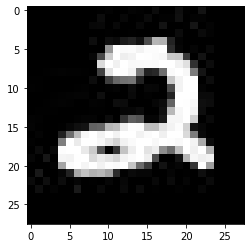

In [2]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt

raw_i = get_data("finn.data", "onnx/mnist-conv/test_data_set_0/input_0.pb")
x = nph.to_array(onnx.load_tensor_from_string(raw_i))
plt.imshow(x.reshape(28,28), cmap='gray')

In [92]:
model = ModelWrapper(build_dir + "/tfc_w1_a1_pynq_deploy.onnx")
iname = model.graph.input[0].name
oname = parent_model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))

Expected network input shape is [1, 784]


Finally, we can call `execute_onnx` on the graph, which will internally call remote execution with the bitfile, grab the results and return a numpy array. You may recall that one "reshape" node was left out of the StreamingDataflowPartition. We'll do that manually with a numpy function call when passing in the input, but everything else in the network ended up inside the StreamingDataflowPartition so that's all we need to do.

In [95]:
import numpy as np
from finn.core.onnx_exec import execute_onnx

input_dict = {iname: x.reshape(ishape)}
ret = execute_onnx(model, input_dict)

In [96]:
ret[oname]

array([[2.]], dtype=float32)

We see that the network correctly predicts this as a digit 2.

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

All the command line prompts here are meant to be executed with `sudo` on the PYNQ board, so we'll use a workaround (`echo password | sudo -S command`) to get that working from this notebook running on the host computer.

**Ensure that your PYNQ board has a working internet connecting for the next steps, since some there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ:

```sudo pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading```

In [75]:
! ssh {options} -t {username}@{ip} -p {port} 'echo {password} | sudo -S pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading'

[sudo] password for xilinx: Collecting git+https://github.com/fbcotter/dataset_loading.git@0.0.4
  Cloning https://github.com/fbcotter/dataset_loading.git (to 0.0.4) to /tmp/pip-hhwx4j3n-build
Connection to 192.168.2.99 closed.


We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the MNIST dataset.

Command to execute on PYNQ:

`python3.6 validate.py --dataset mnist --batchsize 1000`

In [108]:
! ssh {options} -t {username}@{ip} -p {port} 'cd {target_dir_pynq}; echo {password} | sudo -S python3.6 validate.py --dataset mnist --batchsize 1000'

[sudo] password for xilinx: Looking for Train Imgs
Tar File found in data_dir. Not Downloading again
Looking for Train Labels
Tar File found in data_dir. Not Downloading again
Looking for Test Imgs
Tar File found in data_dir. Not Downloading again
Looking for Test Labels
Tar File found in data_dir. Not Downloading again
batch 0 / 10 : total OK 913 NOK 87
batch 1 / 10 : total OK 1800 NOK 200
batch 2 / 10 : total OK 2714 NOK 286
batch 3 / 10 : total OK 3619 NOK 381
batch 4 / 10 : total OK 4535 NOK 465
batch 5 / 10 : total OK 5488 NOK 512
batch 6 / 10 : total OK 6438 NOK 562
batch 7 / 10 : total OK 7399 NOK 601
batch 8 / 10 : total OK 8371 NOK 629
batch 9 / 10 : total OK 9296 NOK 704
Final accuracy: 92.960000
Connection to 192.168.2.99 closed.


We see that the final top-1 accuracy is 92.96%, which is very close to the 93.17% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/brevitas_examples/bnn_pynq). 

### Throughput Test on PYNQ Board <a id='throughput'></a>
In addition to the functional verification, FINN also offers the possibility to measure the network performance directly on the PYNQ board. This can be done using the core function `throughput_test`. In the next section we import the function and execute it.
First we extract the `remote_exec_model` again and pass it to the function. The function returns the metrics of the network as dictionary. 

In [104]:
from finn.core.throughput_test import throughput_test_remote

model = ModelWrapper(build_dir + "/tfc_w1_a1_pynq_deploy.onnx")
res = throughput_test_remote(model, 10000)
print("Network metrics:")
for key in res:
    print(str(key) + ": " + str(res[key]))

Network metrics:
runtime[ms]: 10.43391227722168
throughput[images/s]: 958413.2714850444
DRAM_in_bandwidth[Mb/s]: 751.3960048442748
DRAM_out_bandwidth[Mb/s]: 0.9584132714850445
fclk[mhz]: 100.0
N: 10000


Together with the values for folding we can evaluate the performance of our accelerator. Each layer has a total folding factor of 64 and because the network is fully pipelined, it follows: `II = 64`. II is the initiation interval and indicates how many cycles are needed for one input to be processed. 

In [105]:
II = 64
# frequency in MHz
f_MHz = 100
# expected throughput in MFPS
expected_throughput = f_MHz / II
# measured throughput (FPS) from throughput test, converted to MFPS
measured_throughput = res["throughput[images/s]"] * 0.000001
# peformance
print("We reach approximately " + str(round((measured_throughput / expected_throughput)*100)) + "% of the ideal performance.")

We reach approximately 61% of the ideal performance.


The measured values were recorded with a batch size of 10000 and at a frequency of 100 MHz. We will be improving the efficiency of the generated accelerator examples in the coming FINN releases.